In [1]:
import torch
import json
from pathlib import Path
from sklearn.metrics import matthews_corrcoef, f1_score
import numpy as np
import csv
import itertools
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler 
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from collections import Counter
import logging
import glob
import scipy.stats as stats
import researchpy as rp
import scikit_posthocs as sp
import statsmodels.api as sa
import seaborn as sns
from matplotlib import pyplot
from IPython.display import display, Markdown
from statannot import add_stat_annotation


# Baseline Models

In [2]:
all_files = glob.glob('classification_results/baseline/*.csv')
all_rows = []
for file in all_files:
    df = pd.read_csv(file, index_col=None, header=0)
    all_rows.append(df)
    
baseline_data = pd.concat(all_rows, axis=0, ignore_index=True)
baseline_data['condition'] = baseline_data['condition'].replace({'no_context':'no context', 
                                                    'one_prev_utterance': '1 prev turn',
                                                    'all_prev_utterance': 'all prev turns'
                                                   })
baseline_data

,Unnamed: 0,loss,task_name,info_need,model,num_epochs,condition,acc,f1_other,f1_infoneed,...,precision_weighted,f1_weighted,f1_macro,f1_micro,mcc,report,preds,labels,stopwords_removed,resampled
0,0,None,text_classification,Temperature,NB,None,no context,None,0.750000,0.053571,...,0.989114,0.742204,0.401786,0.604478,None,None,None,None,False,False
1,1,None,text_classification,Temperature,NB,None,no context,None,0.758782,0.055046,...,0.989123,0.750905,0.406914,0.615672,None,None,None,None,False,False
2,2,None,text_classification,Temperature,NB,None,no context,None,0.752941,0.054054,...,0.989117,0.745118,0.403498,0.608209,None,None,None,None,False,False
3,3,None,text_classification,Temperature,NB,None,no context,None,0.812500,0.045455,...,0.983666,0.803914,0.428977,0.686567,None,None,None,None,False,False
4,4,None,text_classification,Temperature,NB,None,no context,None,0.800905,0.063830,...,0.980038,0.789904,0.432367,0.671642,None,None,None,None,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,5,None,text_classification,Ingredient,SVM,None,all prev turns,None,0.179487,0.661376,...,0.472705,0.444797,0.420431,0.520599,None,None,None,None,True,True
3956,6,None,text_classification,Ingredient,SVM,None,all prev turns,None,0.143885,0.698734,...,0.542907,0.449364,0.421310,0.554307,None,None,None,None,True,True
3957,7,None,text_classification,Ingredient,SVM,None,all prev turns,None,0.090323,0.627968,...,0.372288,0.386330,0.359145,0.471910,None,None,None,None,True,True
3958,8,None,text_classification,Ingredient,SVM,None,all prev turns,None,0.040000,0.625000,...,0.323709,0.362079,0.332500,0.460674,None,None,None,None,True,True


## Stopwords vs. No Stopwords

In [3]:
baseline_data_no_stopwords_no_resampling = baseline_data[(baseline_data['stopwords_removed']==True) & (baseline_data['resampled']==False)]


In [4]:
baseline_no_resampling = baseline_data[baseline_data['resampled']==False]
nb_baseline_no_resampling = baseline_no_resampling[baseline_no_resampling['model'] == 'NB']
rf_baseline_no_resampling = baseline_no_resampling[baseline_no_resampling['model'] == 'RF']
svm_baseline_no_resampling = baseline_no_resampling[baseline_no_resampling['model'] == 'SVM']

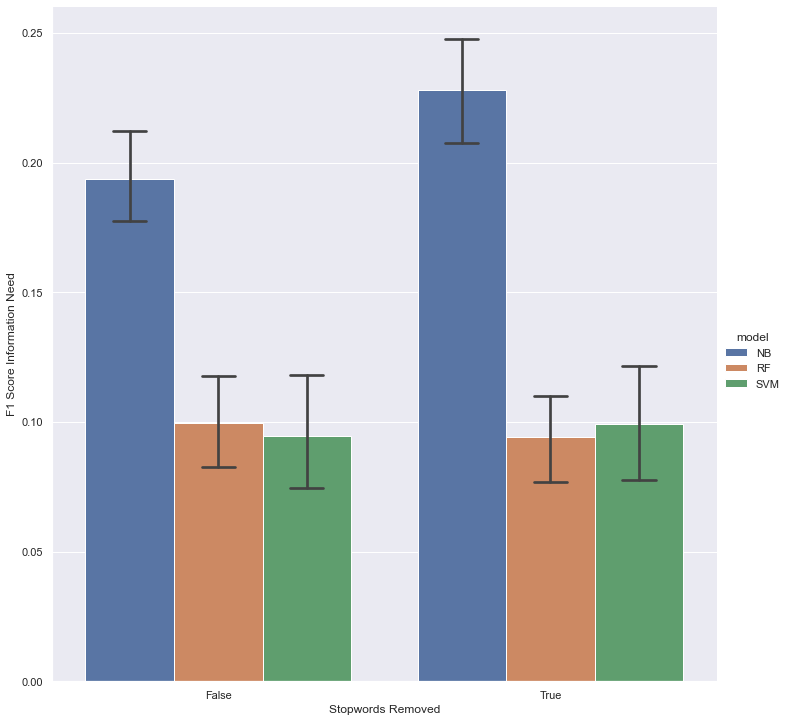

In [5]:
sns.set(style='darkgrid')
model_plot = sns.catplot(x="stopwords_removed", y = "f1_infoneed", 
                         hue="model", 
                         kind="bar", 
                         data=baseline_no_resampling,
                         height=10,
                         capsize=.1)
model_plot.set_axis_labels("Stopwords Removed", "F1 Score Information Need")

In [6]:
display(Markdown("**Overall Performance stopwords-no stopwords**"))
display(stats.ttest_ind(baseline_no_resampling['f1_infoneed'][baseline_no_resampling['stopwords_removed']==True],
                       baseline_no_resampling['f1_infoneed'][baseline_no_resampling['stopwords_removed']==False]))
display(Markdown("**NB Performance stopwords-no stopwords**"))
display(stats.ttest_ind(nb_baseline_no_resampling['f1_infoneed'][nb_baseline_no_resampling['stopwords_removed']==True],
                       nb_baseline_no_resampling['f1_infoneed'][nb_baseline_no_resampling['stopwords_removed']==False]))
display(Markdown("**RF Performance stopwords-no stopwords**"))
display(stats.ttest_ind(rf_baseline_no_resampling['f1_infoneed'][rf_baseline_no_resampling['stopwords_removed']==True],
                       rf_baseline_no_resampling['f1_infoneed'][rf_baseline_no_resampling['stopwords_removed']==False]))
display(Markdown("**SVM Performance stopwords-no stopwords**"))
display(stats.ttest_ind(svm_baseline_no_resampling['f1_infoneed'][svm_baseline_no_resampling['stopwords_removed']==True],
                       svm_baseline_no_resampling['f1_infoneed'][svm_baseline_no_resampling['stopwords_removed']==False]))

**Overall Performance stopwords-no stopwords**

Ttest_indResult(statistic=1.300533242351831, pvalue=0.19356977090427493)

**NB Performance stopwords-no stopwords**

Ttest_indResult(statistic=2.4751205203305906, pvalue=0.01356992257316209)

**RF Performance stopwords-no stopwords**

Ttest_indResult(statistic=-0.4676593124534259, pvalue=0.6401830850788459)

**SVM Performance stopwords-no stopwords**

Ttest_indResult(statistic=0.2865252662467442, pvalue=0.7745660366341307)

### Statistics WITHOUT Stopwords

In [7]:
display(Markdown("**BASELINE: NO CONTEXT - MODEL**"))
no_context_results = baseline_data_no_stopwords_no_resampling[baseline_data_no_stopwords_no_resampling['condition']=='no context']
no_context_model_comparison = stats.f_oneway(no_context_results['f1_infoneed'][no_context_results['model'] == 'NB'],
                                         no_context_results['f1_infoneed'][no_context_results['model'] == 'SVM'],
                                         no_context_results['f1_infoneed'][no_context_results['model'] == 'RF'])
print(no_context_model_comparison)
no_context_model_posthoc = sp.posthoc_ttest(no_context_results, val_col='f1_infoneed', group_col='model',p_adjust='bonferroni')
display(no_context_model_posthoc)
display(rp.summary_cont(no_context_results['f1_infoneed'].groupby(no_context_results['model'])))

display(Markdown("**BASELINE: ONE PREV UTTERANCE - MODEL**"))
one_prev_utterance_results = baseline_data_no_stopwords_no_resampling[baseline_data_no_stopwords_no_resampling['condition']=='1 prev turn']
one_prev_utterance_model_comparison = stats.f_oneway(one_prev_utterance_results['f1_infoneed'][one_prev_utterance_results['model'] == 'NB'],
                                                 one_prev_utterance_results['f1_infoneed'][one_prev_utterance_results['model'] == 'SVM'],
                                                 one_prev_utterance_results['f1_infoneed'][one_prev_utterance_results['model'] == 'RF'])
print(one_prev_utterance_model_comparison)
one_prev_utterance_posthoc = sp.posthoc_ttest(one_prev_utterance_results, val_col='f1_infoneed', group_col='model',p_adjust='bonferroni')
display(one_prev_utterance_posthoc)
display(rp.summary_cont(one_prev_utterance_results['f1_infoneed'].groupby(one_prev_utterance_results['model'])))

display(Markdown("**BASELINE: ALL PREV UTTERANCES - MODEL**"))
all_prev_utterance_results = baseline_data_no_stopwords_no_resampling[baseline_data_no_stopwords_no_resampling['condition']=='all prev turns']
all_prev_utterance_model_comparison = stats.f_oneway(all_prev_utterance_results['f1_infoneed'][all_prev_utterance_results['model'] == 'NB'],
                                                 all_prev_utterance_results['f1_infoneed'][all_prev_utterance_results['model'] == 'SVM'],
                                                 all_prev_utterance_results['f1_infoneed'][all_prev_utterance_results['model'] == 'RF'])
print(all_prev_utterance_model_comparison)
all_prev_utterance_model_posthoc = sp.posthoc_ttest(all_prev_utterance_results, val_col='f1_infoneed', group_col='model',p_adjust='bonferroni')
display(all_prev_utterance_model_posthoc)
display(rp.summary_cont(all_prev_utterance_results['f1_infoneed'].groupby(all_prev_utterance_results['model'])))


display(Markdown("**BASELINE: OVERALL MODEL PERFORMANCE**"))
overall_model_comparison = stats.f_oneway(baseline_data_no_stopwords_no_resampling['f1_infoneed'][baseline_data_no_stopwords_no_resampling['model'] == 'NB'],
                                    baseline_data_no_stopwords_no_resampling['f1_infoneed'][baseline_data_no_stopwords_no_resampling['model'] == 'SVM'],
                                    baseline_data_no_stopwords_no_resampling['f1_infoneed'][baseline_data_no_stopwords_no_resampling['model'] == 'RF'])
print(overall_model_comparison)
overall_model_posthoc = sp.posthoc_ttest(baseline_data_no_stopwords_no_resampling, val_col='f1_infoneed', group_col='model',p_adjust='bonferroni')
display(overall_model_posthoc)
display(rp.summary_cont(baseline_data_no_stopwords_no_resampling['f1_infoneed'].groupby(baseline_data_no_stopwords_no_resampling['model'])))


**BASELINE: NO CONTEXT - MODEL**

F_onewayResult(statistic=1.8767589320860742, pvalue=0.154730663513192)


,NB,RF,SVM
NB,1.000000,0.10712,0.430241
RF,0.107120,1.00000,1.000000
SVM,0.430241,1.00000,1.000000


,N,Mean,SD,SE,95% Conf.,Interval
model,,,,,,
NB,110,0.2368,0.1712,0.0163,0.2044,0.2691
RF,110,0.1830,0.2044,0.0195,0.1444,0.2217
SVM,110,0.1913,0.2758,0.0263,0.1392,0.2434


**BASELINE: ONE PREV UTTERANCE - MODEL**

F_onewayResult(statistic=43.57480825297274, pvalue=1.6724185268475083e-17)


,NB,RF,SVM
NB,1.000000e+00,7.771243e-17,2.158247e-09
RF,7.771243e-17,1.000000e+00,2.612298e-01
SVM,2.158247e-09,2.612298e-01,1.000000e+00


,N,Mean,SD,SE,95% Conf.,Interval
model,,,,,,
NB,110,0.2521,0.1722,0.0164,0.2196,0.2847
RF,110,0.0721,0.1107,0.0106,0.0512,0.0930
SVM,110,0.1049,0.1664,0.0159,0.0734,0.1363


**BASELINE: ALL PREV UTTERANCES - MODEL**

F_onewayResult(statistic=78.28137854734467, pvalue=1.6615651925596827e-28)


,NB,RF,SVM
NB,1.000000e+00,6.978664e-14,1.345880e-18
RF,6.978664e-14,1.000000e+00,1.284210e-04
SVM,1.345880e-18,1.284210e-04,1.000000e+00


,N,Mean,SD,SE,95% Conf.,Interval
model,,,,,,
NB,110,0.1951,0.2064,0.0197,0.1561,0.2341
RF,110,0.0269,0.0625,0.0060,0.0151,0.0387
SVM,110,0.0016,0.0118,0.0011,-0.0006,0.0038


**BASELINE: OVERALL MODEL PERFORMANCE**

F_onewayResult(statistic=58.04794795679267, pvalue=1.465098061489194e-24)


,NB,RF,SVM
NB,1.000000e+00,5.041037e-22,2.443407e-16
RF,5.041037e-22,1.000000e+00,1.000000e+00
SVM,2.443407e-16,1.000000e+00,1.000000e+00


,N,Mean,SD,SE,95% Conf.,Interval
model,,,,,,
NB,330,0.2280,0.1850,0.0102,0.2080,0.2480
RF,330,0.0940,0.1534,0.0084,0.0774,0.1106
SVM,330,0.0993,0.2011,0.0111,0.0775,0.1210


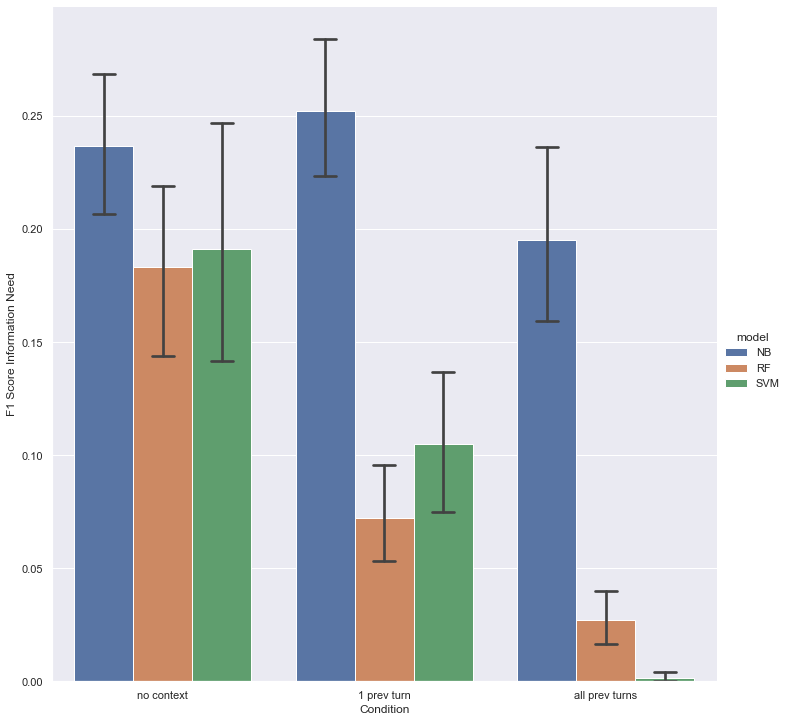

In [8]:
sns.set(style='darkgrid')
model_plot = sns.catplot(x="condition", y = "f1_infoneed", 
                         hue="model", 
                         kind="bar", 
                         data=baseline_data_no_stopwords_no_resampling,
                         height=10,
                         capsize=.1)
model_plot.set_axis_labels("Condition", "F1 Score Information Need")

In [9]:
display(Markdown("**Gaussian Naive Bayes: No Stopwords - No Resampling**"))
baseline_data_no_stopwords_no_resampling.groupby(['model','condition']).agg({'precision_infoneed':['mean'],
                                                          'recall_infoneed':['mean'],
                                                          'f1_infoneed':['mean'],})

**Gaussian Naive Bayes: No Stopwords - No Resampling**

precision_infoneed recall_infoneed f1_infoneed
                                   mean            mean        mean
model condition                                                    
NB    1 prev turn              0.191394        0.606744    0.252121
      all prev turns           0.140946        0.459931    0.195092
      no context               0.191986        0.607208    0.236774
RF    1 prev turn              0.275148        0.043546    0.072103
      all prev turns           0.027883        0.038554    0.026910
      no context               0.349654        0.130197    0.183037
SVM   1 prev turn              0.254977        0.071075    0.104862
      all prev turns           0.011364        0.000887    0.001593
      no context               0.324147        0.145081    0.191322

### Statistics **WITH** Stopwords

In [10]:
baseline_data_stopwords_no_resampling = baseline_data[(baseline_data['stopwords_removed']==False) & (baseline_data['resampled']==False)]
baseline_data_stopwords_no_resampling

,Unnamed: 0,loss,task_name,info_need,model,num_epochs,condition,acc,f1_other,f1_infoneed,...,precision_weighted,f1_weighted,f1_macro,f1_micro,mcc,report,preds,labels,stopwords_removed,resampled
0,0,None,text_classification,Temperature,NB,None,no context,None,0.750000,0.053571,...,0.989114,0.742204,0.401786,0.604478,None,None,None,None,False,False
1,1,None,text_classification,Temperature,NB,None,no context,None,0.758782,0.055046,...,0.989123,0.750905,0.406914,0.615672,None,None,None,None,False,False
2,2,None,text_classification,Temperature,NB,None,no context,None,0.752941,0.054054,...,0.989117,0.745118,0.403498,0.608209,None,None,None,None,False,False
3,3,None,text_classification,Temperature,NB,None,no context,None,0.812500,0.045455,...,0.983666,0.803914,0.428977,0.686567,None,None,None,None,False,False
4,4,None,text_classification,Temperature,NB,None,no context,None,0.800905,0.063830,...,0.980038,0.789904,0.432367,0.671642,None,None,None,None,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2965,5,None,text_classification,Ingredient,SVM,None,all prev turns,None,0.861407,0.000000,...,0.572374,0.651701,0.430704,0.756554,None,None,None,None,False,False
2966,6,None,text_classification,Ingredient,SVM,None,all prev turns,None,0.861407,0.000000,...,0.572374,0.651701,0.430704,0.756554,None,None,None,None,False,False
2967,7,None,text_classification,Ingredient,SVM,None,all prev turns,None,0.858974,0.000000,...,0.566721,0.646644,0.429487,0.752809,None,None,None,None,False,False
2968,8,None,text_classification,Ingredient,SVM,None,all prev turns,None,0.858974,0.000000,...,0.566721,0.646644,0.429487,0.752809,None,None,None,None,False,False


In [11]:
display(Markdown("**BASELINE: NO CONTEXT - MODEL**"))
no_context_results = baseline_data_stopwords_no_resampling[baseline_data_stopwords_no_resampling['condition']=='no context']
no_context_model_comparison = stats.f_oneway(no_context_results['f1_infoneed'][no_context_results['model'] == 'NB'],
                                         no_context_results['f1_infoneed'][no_context_results['model'] == 'SVM'],
                                         no_context_results['f1_infoneed'][no_context_results['model'] == 'RF'])
print(no_context_model_comparison)
no_context_model_posthoc = sp.posthoc_ttest(no_context_results, val_col='f1_infoneed', group_col='model',p_adjust='bonferroni')
display(no_context_model_posthoc)
display(rp.summary_cont(no_context_results['f1_infoneed'].groupby(no_context_results['model'])))

display(Markdown("**BASELINE: ONE PREV UTTERANCE - MODEL**"))
one_prev_utterance_results = baseline_data_stopwords_no_resampling[baseline_data_stopwords_no_resampling['condition']=='1 prev turn']
one_prev_utterance_model_comparison = stats.f_oneway(one_prev_utterance_results['f1_infoneed'][one_prev_utterance_results['model'] == 'NB'],
                                                 one_prev_utterance_results['f1_infoneed'][one_prev_utterance_results['model'] == 'SVM'],
                                                 one_prev_utterance_results['f1_infoneed'][one_prev_utterance_results['model'] == 'RF'])
print(one_prev_utterance_model_comparison)
one_prev_utterance_posthoc = sp.posthoc_ttest(one_prev_utterance_results, val_col='f1_infoneed', group_col='model',p_adjust='bonferroni')
display(one_prev_utterance_posthoc)
display(rp.summary_cont(one_prev_utterance_results['f1_infoneed'].groupby(one_prev_utterance_results['model'])))

display(Markdown("**BASELINE: ALL PREV UTTERANCES - MODEL**"))
all_prev_utterance_results = baseline_data_stopwords_no_resampling[baseline_data_stopwords_no_resampling['condition']=='all prev turns']
all_prev_utterance_model_comparison = stats.f_oneway(all_prev_utterance_results['f1_infoneed'][all_prev_utterance_results['model'] == 'NB'],
                                                 all_prev_utterance_results['f1_infoneed'][all_prev_utterance_results['model'] == 'SVM'],
                                                 all_prev_utterance_results['f1_infoneed'][all_prev_utterance_results['model'] == 'RF'])
print(all_prev_utterance_model_comparison)
all_prev_utterance_model_posthoc = sp.posthoc_ttest(all_prev_utterance_results, val_col='f1_infoneed', group_col='model',p_adjust='bonferroni')
display(all_prev_utterance_model_posthoc)
display(rp.summary_cont(all_prev_utterance_results['f1_infoneed'].groupby(all_prev_utterance_results['model'])))


display(Markdown("**BASELINE: OVERALL MODEL PERFORMANCE**"))
overall_model_comparison = stats.f_oneway(baseline_data_stopwords_no_resampling['f1_infoneed'][baseline_data_stopwords_no_resampling['model'] == 'NB'],
                                    baseline_data_stopwords_no_resampling['f1_infoneed'][baseline_data_stopwords_no_resampling['model'] == 'SVM'],
                                    baseline_data_stopwords_no_resampling['f1_infoneed'][baseline_data_stopwords_no_resampling['model'] == 'RF'])
print(overall_model_comparison)
overall_model_posthoc = sp.posthoc_ttest(baseline_data_stopwords_no_resampling, val_col='f1_infoneed', group_col='model',p_adjust='bonferroni')
display(overall_model_posthoc)
display(rp.summary_cont(baseline_data_stopwords_no_resampling['f1_infoneed'].groupby(baseline_data_stopwords_no_resampling['model'])))


**BASELINE: NO CONTEXT - MODEL**

F_onewayResult(statistic=0.09690591472133668, pvalue=0.9076674534524957)


,NB,RF,SVM
NB,1.0,1.0,1.0
RF,1.0,1.0,1.0
SVM,1.0,1.0,1.0


,N,Mean,SD,SE,95% Conf.,Interval
model,,,,,,
NB,110,0.1862,0.1567,0.0149,0.1566,0.2159
RF,110,0.1946,0.2125,0.0203,0.1545,0.2348
SVM,110,0.1816,0.2828,0.0270,0.1281,0.2350


**BASELINE: ONE PREV UTTERANCE - MODEL**

F_onewayResult(statistic=23.0665167298595, pvalue=4.2544439083248304e-10)


,NB,RF,SVM
NB,1.000000e+00,2.636861e-10,0.000014
RF,2.636861e-10,1.000000e+00,0.575166
SVM,1.422054e-05,5.751657e-01,1.000000


,N,Mean,SD,SE,95% Conf.,Interval
model,,,,,,
NB,110,0.2149,0.1754,0.0167,0.1818,0.2480
RF,110,0.0753,0.1236,0.0118,0.0520,0.0987
SVM,110,0.1026,0.1796,0.0171,0.0686,0.1365


**BASELINE: ALL PREV UTTERANCES - MODEL**

F_onewayResult(statistic=82.59963936752372, pvalue=9.19408430582491e-30)


,NB,RF,SVM
NB,1.000000e+00,6.787182e-14,1.183509e-20
RF,6.787182e-14,1.000000e+00,5.308208e-05
SVM,1.183509e-20,5.308208e-05,1.000000e+00


,N,Mean,SD,SE,95% Conf.,Interval
model,,,,,,
NB,110,0.1799,0.1797,0.0171,0.1459,0.2138
RF,110,0.0293,0.0701,0.0067,0.0161,0.0426
SVM,110,0.0000,0.0000,0.0000,NaN,NaN


**BASELINE: OVERALL MODEL PERFORMANCE**

F_onewayResult(statistic=31.20954338590687, pvalue=7.19786416999313e-14)


,NB,RF,SVM
NB,1.000000e+00,4.287325e-12,1.344002e-10
RF,4.287325e-12,1.000000e+00,1.000000e+00
SVM,1.344002e-10,1.000000e+00,1.000000e+00


,N,Mean,SD,SE,95% Conf.,Interval
model,,,,,,
NB,330,0.1937,0.1711,0.0094,0.1751,0.2122
RF,330,0.0998,0.1629,0.0090,0.0821,0.1174
SVM,330,0.0947,0.2067,0.0114,0.0723,0.1171


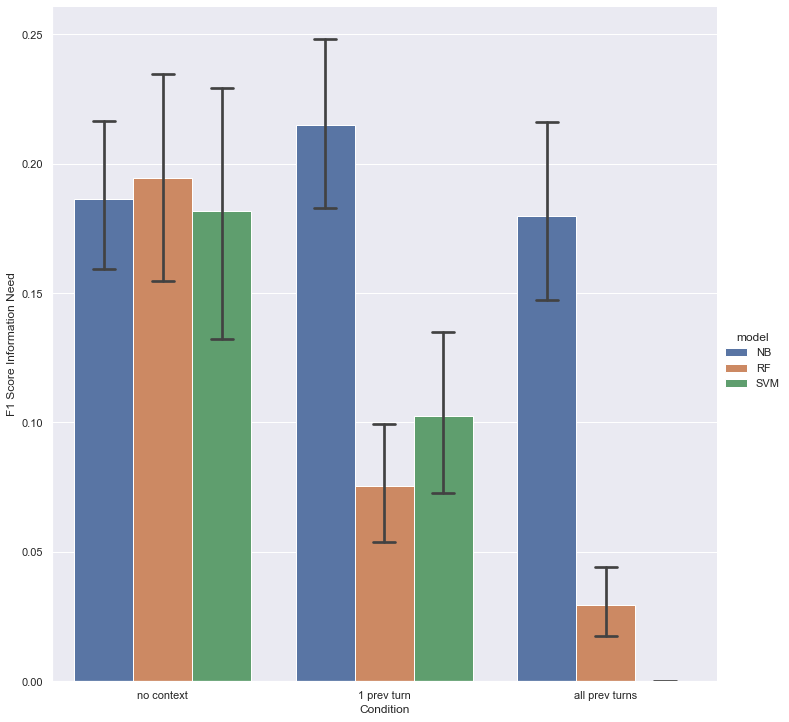

In [12]:
sns.set(style='darkgrid')
model_plot = sns.catplot(x="condition", y = "f1_infoneed", 
                         hue="model", 
                         kind="bar", 
                         data=baseline_data_stopwords_no_resampling,
                         height=10,
                         capsize=.1)
model_plot.set_axis_labels("Condition", "F1 Score Information Need")

In [13]:
nb_baseline_stopwords_no_resampling = baseline_data[(baseline_data['stopwords_removed']==True) & (baseline_data['resampled']==False) & (baseline_data['model']=="NB")]

In [14]:
nb_baseline_stopwords_no_resampling

,Unnamed: 0,loss,task_name,info_need,model,num_epochs,condition,acc,f1_other,f1_infoneed,...,precision_weighted,f1_weighted,f1_macro,f1_micro,mcc,report,preds,labels,stopwords_removed,resampled
330,0,None,text_classification,Temperature,NB,None,no context,None,0.958743,0.222222,...,0.990205,0.950498,0.590482,0.921642,None,None,None,None,True,False
331,1,None,text_classification,Temperature,NB,None,no context,None,0.990476,0.545455,...,0.993004,0.985495,0.767965,0.981343,None,None,None,None,True,False
332,2,None,text_classification,Temperature,NB,None,no context,None,0.990512,0.444444,...,0.988763,0.984400,0.717478,0.981343,None,None,None,None,True,False
333,3,None,text_classification,Temperature,NB,None,no context,None,0.988593,0.400000,...,0.988216,0.982004,0.694297,0.977612,None,None,None,None,True,False
334,4,None,text_classification,Temperature,NB,None,no context,None,0.984674,0.428571,...,0.985734,0.976374,0.706623,0.970149,None,None,None,None,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,5,None,text_classification,Ingredient,NB,None,all prev turns,None,0.338583,0.400000,...,0.689021,0.353534,0.369291,0.370787,None,None,None,None,True,False
656,6,None,text_classification,Ingredient,NB,None,all prev turns,None,0.547619,0.232323,...,0.561525,0.470862,0.389971,0.430712,None,None,None,None,True,False
657,7,None,text_classification,Ingredient,NB,None,all prev turns,None,0.629412,0.350515,...,0.645161,0.560471,0.489964,0.528090,None,None,None,None,True,False
658,8,None,text_classification,Ingredient,NB,None,all prev turns,None,0.457516,0.271930,...,0.549175,0.411641,0.364723,0.378277,None,None,None,None,True,False


In [15]:
display(Markdown("**Gaussian Naive Bayes: Stopwords - No Resampling**"))
nb_baseline_stopwords_no_resampling.groupby(['info_need','condition']).agg({'precision_infoneed':['mean'],
                                                          'recall_infoneed':['mean'],
                                                          'f1_infoneed':['mean'],})

**Gaussian Naive Bayes: Stopwords - No Resampling**

precision_infoneed recall_infoneed  \
                                               mean            mean   
info_need         condition                                           
Amount            1 prev turn              0.470849        0.533466   
                  all prev turns           0.192397        0.684840   
                  no context               0.269785        0.865691   
Cooking technique 1 prev turn              0.163136        0.595238   
                  all prev turns           0.179851        0.404762   
                  no context               0.196673        0.314286   
Equipment         1 prev turn              0.047726        0.600000   
                  all prev turns           0.015063        0.475000   
                  no context               0.029217        0.700000   
Ingredient        1 prev turn              0.383267        0.369604   
                  all prev turns           0.231950        0.613963   
                  no context               0.378538        0.345338   
Knowledge         1 prev turn              0.023577        0.460000   
                  all prev turns           0.001047        0.040000   
                  no context               0.025645        0.720000   
Meal              1 prev turn              0.038000        0.500000   
                  all prev turns           0.204855        0.450000   
                  no context               0.014104        0.450000   
Miscellaneous     1 prev turn              0.027537        0.650000   
                  all prev turns           0.023099        0.225000   
                  no context               0.025900        0.650000   
Preparation       1 prev turn              0.356728        0.726418   
                  all prev turns           0.329193        0.757416   
                  no context               0.518624        0.427051   
Recipe            1 prev turn              0.187275        0.735952   
                  all prev turns           0.271985        0.565714   
                  no context               0.187674        0.662619   
Temperature       1 prev turn              0.231589        0.716667   
                  all prev turns           0.018875        0.258333   
                  no context               0.293690        0.708333   
Time              1 prev turn              0.175649        0.786842   
                  all prev turns           0.082088        0.584211   
                  no context               0.171990        0.835965   

                                 f1_infoneed  
                                        mean  
info_need         condition                   
Amount            1 prev turn       0.493339  
                  all prev turns    0.299507  
                  no context        0.410472  
Cooking technique 1 prev turn       0.254117  
                  all prev turns    0.240217  
                  no context        0.232760  
Equipment         1 prev turn       0.088246  
                  all prev turns    0.029126  
                  no context        0.056031  
Ingredient        1 prev turn       0.373826  
                  all prev turns    0.334082  
                  no context        0.356611  
Knowledge         1 prev turn       0.044813  
                  all prev turns    0.002041  
                  no context        0.049509  
Meal              1 prev turn       0.070037  
                  all prev turns    0.209517  
                  no context        0.027250  
Miscellaneous     1 prev turn       0.052781  
                  all prev turns    0.041277  
                  no context        0.049802  
Preparation       1 prev turn       0.477155  
                  all prev turns    0.457189  
                  no context        0.456171  
Recipe            1 prev turn       0.295905  
                  all prev turns    0.361203  
                  no context        0.286588  
Temperature       1 prev turn       0.336602  
                  a

In [16]:
display(Markdown("**Comparison GNB stopwords - no stopwords**"))
nb_baseline_no_resampling = baseline_data[(baseline_data['resampled']==False) & (baseline_data['model']=="NB")]
display(rp.summary_cont(nb_baseline_no_resampling['f1_infoneed'].groupby(nb_baseline_no_resampling['stopwords_removed'])))
display(stats.ttest_ind(nb_baseline_no_resampling['f1_infoneed'][nb_baseline_no_resampling['stopwords_removed']==True],
                       nb_baseline_no_resampling['f1_infoneed'][nb_baseline_no_resampling['stopwords_removed']==False]))
display(Markdown("**=> difference**"))

**Comparison GNB stopwords - no stopwords**

,N,Mean,SD,SE,95% Conf.,Interval
stopwords_removed,,,,,,
False,330,0.1937,0.1711,0.0094,0.1751,0.2122
True,330,0.2280,0.1850,0.0102,0.2080,0.2480


Ttest_indResult(statistic=2.4751205203305906, pvalue=0.01356992257316209)

**=> difference**

# BERT Experiments

In [21]:
level1_experiment_results = pd.DataFrame(columns=['loss', 'task_name', 'info_need','model', 'num_epochs', 'condition',
                            'acc','f1_other','f1_infoneed','precision_infoneed','recall_infoneed',
                            'recall_other','precision_other','recall_macro','precision_macro',
                            'recall_micro','precision_micro','recall_weighted','precision_weighted',
                            'f1_weighted','f1_macro','f1_micro','mcc','report','preds','labels'])
all_files = glob.glob('classification_results/level_1/*.json')
all_rows = []
for file in all_files:
    with open(file) as data_file:    
        data = json.load(data_file)  
    for fold in data:
        temp_df = pd.json_normalize(fold)
        level1_experiment_results = level1_experiment_results.append(temp_df, ignore_index = True)


In [23]:
level1_experiment_results = level1_experiment_results[level1_experiment_results.condition!='entire_history']
level1_experiment_results['condition']=level1_experiment_results['condition'].replace({'no_context':'no context', 
                       'one_prev_utterance': '1 prev turn',
                       'all_prev_utterance': 'all prev turns'
                       })
level1_experiment_results

,loss,task_name,info_need,model,num_epochs,condition,acc,f1_other,f1_infoneed,precision_infoneed,...,precision_micro,recall_weighted,precision_weighted,f1_weighted,f1_macro,f1_micro,mcc,report,preds,labels
0,0.483297,text_classification,Amount,bert-base-multilingual-cased,4,all prev turns,0.938017,0.962594,0.819277,0.850000,...,0.938017,0.938017,0.936709,0.937128,0.890935,0.938017,0.782674,precision recall f1-score ...,"[Amount, Amount, Other, Amount, Amount, Other,...","[Amount, Amount, Other, Amount, Amount, Other,..."
1,0.351210,text_classification,Amount,bert-base-multilingual-cased,4,all prev turns,0.904959,0.941476,0.747253,0.708333,...,0.904959,0.904959,0.910026,0.906965,0.844364,0.904959,0.690527,precision recall f1-score ...,"[Other, Other, Amount, Other, Other, Amount, O...","[Other, Other, Amount, Other, Other, Other, Ot..."
2,0.689041,text_classification,Amount,bert-base-multilingual-cased,4,all prev turns,0.822314,0.902494,0.000000,0.000000,...,0.822314,0.822314,0.676200,0.742134,0.451247,0.822314,0.000000,precision recall f1-score ...,"[Other, Other, Other, Other, Other, Other, Oth...","[Other, Other, Other, Other, Other, Amount, Ot..."
3,0.697848,text_classification,Amount,bert-base-multilingual-cased,4,all prev turns,0.177686,0.000000,0.301754,0.177686,...,0.177686,0.177686,0.031572,0.053618,0.150877,0.177686,0.000000,precision recall f1-score ...,"[Amount, Amount, Amount, Amount, Amount, Amoun...","[Other, Other, Other, Amount, Other, Amount, O..."
4,0.538392,text_classification,Amount,bert-base-multilingual-cased,4,all prev turns,0.876033,0.923858,0.666667,0.652174,...,0.876033,0.876033,0.878317,0.877096,0.795262,0.876033,0.590791,precision recall f1-score ...,"[Other, Other, Other, Other, Amount, Amount, O...","[Other, Other, Other, Other, Amount, Amount, O..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,0.366908,text_classification,Time,xlm-roberta-base,4,1 prev turn,0.929752,0.961276,0.622222,0.500000,...,0.929752,0.929752,0.951842,0.937458,0.791749,0.929752,0.608261,precision recall f1-score ...,"[Time, Other, Other, Other, Other, Time, Time,...","[Time, Other, Other, Time, Other, Other, Time,..."
1316,0.651086,text_classification,Time,xlm-roberta-base,4,1 prev turn,0.962810,0.979955,0.742857,0.722222,...,0.962810,0.962810,0.963884,0.963300,0.861406,0.962810,0.723173,precision recall f1-score ...,"[Other, Time, Other, Other, Time, Other, Other...","[Other, Time, Other, Other, Time, Other, Other..."
1317,0.703812,text_classification,Time,xlm-roberta-base,4,1 prev turn,0.929752,0.963597,0.000000,0.000000,...,0.929752,0.929752,0.864439,0.895907,0.481799,0.929752,0.000000,precision recall f1-score ...,"[Other, Other, Other, Other, Other, Other, Oth...","[Other, Other, Other, Other, Other, Other, Tim..."
1318,0.249215,text_classification,Time,xlm-roberta-base,4,1 prev turn,0.958506,0.977376,0.750000,0.625000,...,0.958506,0.958506,0.970801,0.962280,0.863688,0.958506,0.746191,precision recall f1-score ...,"[Other, Other, Time, Other, Other, Other, Othe...","[Other, Other, Time, Other, Other, Other, Othe..."


In [25]:
display(Markdown("**NO CONTEXT - MODEL**"))
no_context_results = level1_experiment_results[level1_experiment_results['condition']=='no context']
no_context_model_comparison = stats.f_oneway(no_context_results['f1_infoneed'][no_context_results['model'] == 'deepset/gbert-base'],
                                         no_context_results['f1_infoneed'][no_context_results['model'] == 'xlm-roberta-base'],
                                         no_context_results['f1_infoneed'][no_context_results['model'] == 'bert-base-multilingual-cased'])
print(no_context_model_comparison)
no_context_model_posthoc = sp.posthoc_ttest(no_context_results, val_col='f1_infoneed', group_col='model',p_adjust='bonferroni')
display(no_context_model_posthoc)
display(rp.summary_cont(no_context_results['f1_infoneed'].groupby(no_context_results['model'])))

display(Markdown("**ONE PREV UTTERANCE - MODEL**"))
one_prev_utterance_results = level1_experiment_results[level1_experiment_results['condition']=='1 prev turn']
one_prev_utterance_model_comparison = stats.f_oneway(one_prev_utterance_results['f1_infoneed'][one_prev_utterance_results['model'] == 'deepset/gbert-base'],
                                                 one_prev_utterance_results['f1_infoneed'][one_prev_utterance_results['model'] == 'xlm-roberta-base'],
                                                 one_prev_utterance_results['f1_infoneed'][one_prev_utterance_results['model'] == 'bert-base-multilingual-cased'])
print(one_prev_utterance_model_comparison)
one_prev_utterance_posthoc = sp.posthoc_ttest(one_prev_utterance_results, val_col='f1_infoneed', group_col='model',p_adjust='bonferroni')
display(one_prev_utterance_posthoc)
display(rp.summary_cont(one_prev_utterance_results['f1_infoneed'].groupby(one_prev_utterance_results['model'])))

display(Markdown("**ALL PREV UTTERANCES - MODEL**"))
all_prev_utterance_results = level1_experiment_results[level1_experiment_results['condition']=='all prev turns']
all_prev_utterance_model_comparison = stats.f_oneway(all_prev_utterance_results['f1_infoneed'][all_prev_utterance_results['model'] == 'deepset/gbert-base'],
                                                 all_prev_utterance_results['f1_infoneed'][all_prev_utterance_results['model'] == 'xlm-roberta-base'],
                                                 all_prev_utterance_results['f1_infoneed'][all_prev_utterance_results['model'] == 'bert-base-multilingual-cased'])
print(all_prev_utterance_model_comparison)
all_prev_utterance_model_posthoc = sp.posthoc_ttest(all_prev_utterance_results, val_col='f1_infoneed', group_col='model',p_adjust='bonferroni')
display(all_prev_utterance_model_posthoc)
display(rp.summary_cont(all_prev_utterance_results['f1_infoneed'].groupby(all_prev_utterance_results['model'])))


display(Markdown("**OVERALL MODEL PERFORMANCE**"))
overall_model_comparison = stats.f_oneway(level1_experiment_results['f1_infoneed'][level1_experiment_results['model'] == 'deepset/gbert-base'],
                                    level1_experiment_results['f1_infoneed'][level1_experiment_results['model'] == 'xlm-roberta-base'],
                                    level1_experiment_results['f1_infoneed'][level1_experiment_results['model'] == 'bert-base-multilingual-cased'])
print(overall_model_comparison)
overall_model_posthoc = sp.posthoc_ttest(level1_experiment_results, val_col='f1_infoneed', group_col='model',p_adjust='bonferroni')
display(overall_model_posthoc)
display(rp.summary_cont(level1_experiment_results['f1_infoneed'].groupby(level1_experiment_results['model'])))


**NO CONTEXT - MODEL**

F_onewayResult(statistic=4.172631144189436, pvalue=0.01624003408546242)


,bert-base-multilingual-cased,deepset/gbert-base,xlm-roberta-base
bert-base-multilingual-cased,1.000000,0.402632,0.500115
deepset/gbert-base,0.402632,1.000000,0.013147
xlm-roberta-base,0.500115,0.013147,1.000000


,N,Mean,SD,SE,95% Conf.,Interval
model,,,,,,
bert-base-multilingual-cased,110,0.3418,0.3529,0.0336,0.2751,0.4084
deepset/gbert-base,110,0.4143,0.3628,0.0346,0.3457,0.4828
xlm-roberta-base,110,0.2761,0.3490,0.0333,0.2101,0.3420


**ONE PREV UTTERANCE - MODEL**

F_onewayResult(statistic=11.633954289602839, pvalue=1.3155291023211626e-05)


,bert-base-multilingual-cased,deepset/gbert-base,xlm-roberta-base
bert-base-multilingual-cased,1.000000,0.342004,0.004499
deepset/gbert-base,0.342004,1.000000,0.000008
xlm-roberta-base,0.004499,0.000008,1.000000


,N,Mean,SD,SE,95% Conf.,Interval
model,,,,,,
bert-base-multilingual-cased,110,0.3446,0.3494,0.0333,0.2785,0.4106
deepset/gbert-base,110,0.4211,0.3660,0.0349,0.3519,0.4903
xlm-roberta-base,110,0.2036,0.2991,0.0285,0.1470,0.2601


**ALL PREV UTTERANCES - MODEL**

F_onewayResult(statistic=12.244629350584637, pvalue=7.446224271974006e-06)


,bert-base-multilingual-cased,deepset/gbert-base,xlm-roberta-base
bert-base-multilingual-cased,1.000000,0.002718,0.687219
deepset/gbert-base,0.002718,1.000000,0.000030
xlm-roberta-base,0.687219,0.000030,1.000000


,N,Mean,SD,SE,95% Conf.,Interval
model,,,,,,
bert-base-multilingual-cased,110,0.2282,0.2768,0.0264,0.1759,0.2805
deepset/gbert-base,110,0.3787,0.3788,0.0361,0.3071,0.4503
xlm-roberta-base,110,0.1864,0.2359,0.0225,0.1418,0.2309


**OVERALL MODEL PERFORMANCE**

F_onewayResult(statistic=24.669353046255857, pvalue=3.510884801144857e-11)


,bert-base-multilingual-cased,deepset/gbert-base,xlm-roberta-base
bert-base-multilingual-cased,1.000000,8.219501e-04,2.431692e-03
deepset/gbert-base,0.000822,1.000000e+00,2.109681e-11
xlm-roberta-base,0.002432,2.109681e-11,1.000000e+00


,N,Mean,SD,SE,95% Conf.,Interval
model,,,,,,
bert-base-multilingual-cased,330,0.3048,0.3317,0.0183,0.2689,0.3408
deepset/gbert-base,330,0.4047,0.3686,0.0203,0.3648,0.4446
xlm-roberta-base,330,0.2220,0.2999,0.0165,0.1895,0.2545


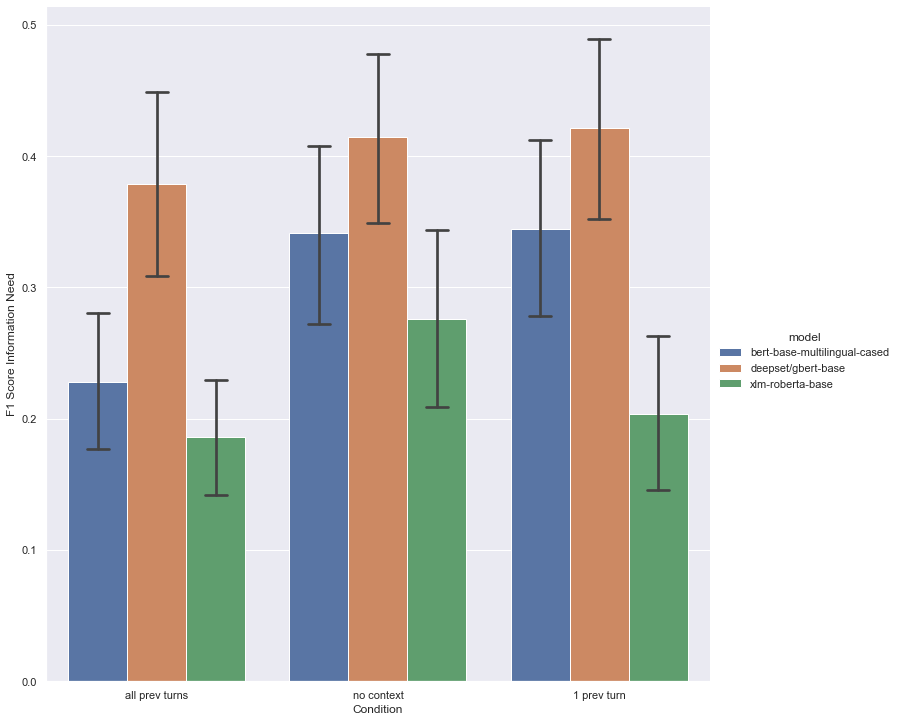

In [26]:
sns.set(style='darkgrid')
model_plot = sns.catplot(x="condition", y = "f1_infoneed", 
                         hue="model", 
                         kind="bar", 
                         data=level1_experiment_results,
                         height=10,
                         capsize=.1)
model_plot.set_axis_labels("Condition", "F1 Score Information Need")

In [27]:
level1_experiment_results.groupby(['info_need','model','condition']).agg({'precision_infoneed':['mean'],
                                                          'recall_infoneed':['mean'],
                                                          'f1_infoneed':['mean'],})

precision_infoneed  \
                                                                    mean   
info_need model                        condition                           
Amount    bert-base-multilingual-cased 1 prev turn              0.859401   
                                       all prev turns           0.561917   
                                       no context               0.871988   
          deepset/gbert-base           1 prev turn              0.905247   
                                       all prev turns           0.885121   
...                                                                  ...   
Time      deepset/gbert-base           all prev turns           0.592243   
                                       no context               0.889891   
          xlm-roberta-base             1 prev turn              0.413657   
                                       all prev turns           0.117281   
                                       no context               0.846143   

                                                      recall_infoneed  \
                                                                 mean   
info_need model                        condition                        
Amount    bert-base-multilingual-cased 1 prev turn           0.898679   
                                       all prev turns        0.604440   
                                       no context            0.894397   
          deepset/gbert-base           1 prev turn           0.891860   
                                       all prev turns        0.894715   
...                                                               ...   
Time      deepset/gbert-base           all prev turns        0.766544   
                                       no context            0.881250   
          xlm-roberta-base             1 prev turn           0.525368   
                                       all prev turns        0.408456   
                                       no context            0.844853   

                                                      f1_infoneed  
                                                             mean  
info_need model                        condition                   
Amount    bert-base-multilingual-cased 1 prev turn       0.876497  
                                       all prev turns    0.550198  
                                       no context        0.881514  
          deepset/gbert-base           1 prev turn       0.896906  
                                       all prev turns    0.886241  
...                                                           ...  
Time      deepset/gbert-base           all prev turns    0.590740  
                                       no context        0.881113  
          xlm-roberta-base             1 prev turn       0.415022  
                                       all prev turns    0.154169  
                                       no context        0.837106  

[99 rows x 3 columns]

In [28]:
gbert_results = level1_experiment_results[level1_experiment_results['model']=='deepset/gbert-base']


In [29]:
display(Markdown("**MEAN GBERT results**"))
gbert_results['f1_infoneed'].mean()

**MEAN GBERT results**

0.4046983140170653

In [30]:
gbert_results.groupby(['info_need','condition']).agg({'precision_infoneed':['mean'],
                                                          'recall_infoneed':['mean'],
                                                          'f1_infoneed':['mean'],})

precision_infoneed recall_infoneed  \
                                               mean            mean   
info_need         condition                                           
Amount            1 prev turn              0.905247        0.891860   
                  all prev turns           0.885121        0.894715   
                  no context               0.904662        0.914799   
Cooking technique 1 prev turn              0.605670        0.554474   
                  all prev turns           0.721192        0.726842   
                  no context               0.366133        0.516579   
Equipment         1 prev turn              0.088333        0.200000   
                  all prev turns           0.000000        0.000000   
                  no context               0.000000        0.000000   
Ingredient        1 prev turn              0.646140        0.699328   
                  all prev turns           0.575303        0.661163   
                  no context               0.643141        0.716511   
Knowledge         1 prev turn              0.000000        0.000000   
                  all prev turns           0.000000        0.000000   
                  no context               0.160000        0.110000   
Meal              1 prev turn              0.000000        0.000000   
                  all prev turns           0.000000        0.000000   
                  no context               0.000000        0.000000   
Miscellaneous     1 prev turn              0.000000        0.000000   
                  all prev turns           0.000000        0.000000   
                  no context               0.125000        0.050000   
Preparation       1 prev turn              0.681468        0.761656   
                  all prev turns           0.758524        0.738571   
                  no context               0.646702        0.758427   
Recipe            1 prev turn              0.662077        0.666959   
                  all prev turns           0.653225        0.709064   
                  no context               0.678705        0.581579   
Temperature       1 prev turn              0.228571        0.200000   
                  all prev turns           0.000000        0.000000   
                  no context               0.200000        0.216667   
Time              1 prev turn              0.833305        0.833824   
                  all prev turns           0.592243        0.766544   
                  no context               0.889891        0.881250   

                                 f1_infoneed  
                                        mean  
info_need         condition                   
Amount            1 prev turn       0.896906  
                  all prev turns    0.886241  
                  no context        0.908741  
Cooking technique 1 prev turn       0.566466  
                  all prev turns    0.716068  
                  no context        0.407180  
Equipment         1 prev turn       0.119170  
                  all prev turns    0.000000  
                  no context        0.000000  
Ingredient        1 prev turn       0.666674  
                  all prev turns    0.594730  
                  no context        0.671831  
Knowledge         1 prev turn       0.000000  
                  all prev turns    0.000000  
                  no context        0.126667  
Meal              1 prev turn       0.000000  
                  all prev turns    0.000000  
                  no context        0.000000  
Miscellaneous     1 prev turn       0.000000  
                  all prev turns    0.000000  
                  no context        0.065000  
Preparation       1 prev turn       0.696317  
                  all prev turns    0.746483  
                  no context        0.695527  
Recipe            1 prev turn       0.659531  
                  all prev turns    0.631484  
                  no context        0.604488  
Temperature       1 prev turn       0.200000  
                  a

In [31]:
rp.summary_cont(gbert_results['f1_infoneed'])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,f1_infoneed,330.0,0.4047,0.3686,0.0203,0.3648,0.4446


In [32]:
rp.summary_cont(gbert_results.groupby(['info_need','condition'])['f1_infoneed'])

N    Mean      SD      SE  95% Conf.  \
info_need         condition                                               
Amount            1 prev turn     10  0.8969  0.0290  0.0092     0.8762   
                  all prev turns  10  0.8862  0.0737  0.0233     0.8335   
                  no context      10  0.9087  0.0217  0.0069     0.8932   
Cooking technique 1 prev turn     10  0.5665  0.1385  0.0438     0.4674   
                  all prev turns  10  0.7161  0.0783  0.0248     0.6600   
                  no context      10  0.4072  0.0883  0.0279     0.3440   
Equipment         1 prev turn     10  0.1192  0.1972  0.0624    -0.0219   
                  all prev turns  10  0.0000  0.0000  0.0000        NaN   
                  no context      10  0.0000  0.0000  0.0000        NaN   
Ingredient        1 prev turn     10  0.6667  0.0537  0.0170     0.6282   
                  all prev turns  10  0.5947  0.2399  0.0759     0.4231   
                  no context      10  0.6718  0.0542  0.0171     0.6331   
Knowledge         1 prev turn     10  0.0000  0.0000  0.0000        NaN   
                  all prev turns  10  0.0000  0.0000  0.0000        NaN   
                  no context      10  0.1267  0.2675  0.0846    -0.0647   
Meal              1 prev turn     10  0.0000  0.0000  0.0000        NaN   
                  all prev turns  10  0.0000  0.0000  0.0000        NaN   
                  no context      10  0.0000  0.0000  0.0000        NaN   
Miscellaneous     1 prev turn     10  0.0000  0.0000  0.0000        NaN   
                  all prev turns  10  0.0000  0.0000  0.0000        NaN   
                  no context      10  0.0650  0.1415  0.0448    -0.0362   
Preparation       1 prev turn     10  0.6963  0.0972  0.0307     0.6268   
                  all prev turns  10  0.7465  0.0347  0.0110     0.7216   
                  no context      10  0.6955  0.0287  0.0091     0.6750   
Recipe            1 prev turn     10  0.6595  0.1107  0.0350     0.5804   
                  all prev turns  10  0.6315  0.1877  0.0593     0.4972   
                  no context      10  0.6045  0.0720  0.0228     0.5530   
Temperature       1 prev turn     10  0.2000  0.3399  0.1075    -0.0432   
                  all prev turns  10  0.0000  0.0000  0.0000        NaN   
                  no context      10  0.1967  0.3245  0.1026    -0.0355   
Time              1 prev turn     10  0.8270  0.0610  0.0193     0.7834   
                  all prev turns  10  0.5907  0.3164  0.1001     0.3644   
                  no context      10  0.8811  0.0525  0.0166     0.8436   

                                  Interval  
info_need         condition                 
Amount            1 prev turn       0.9176  
                  all prev turns    0.9390  
                  no context        0.9243  
Cooking technique 1 prev turn       0.6656  
                  all prev turns    0.7721  
                  no context        0.4704  
Equipment         1 prev turn       0.2603  
                  all prev turns       NaN  
                  no context           NaN  
Ingredient        1 prev turn       0.7051  
                  all prev turns    0.7664  
                  no context        0.7106  
Knowledge         1 prev turn          NaN  
                  all prev turns       NaN  
                  no context        0.3180  
Meal              1 prev turn          NaN  
                  all prev turns       NaN  
                  no context           NaN  
Miscellaneous     1 prev turn          NaN  
                  all prev turns       NaN  
                  no context        0.1662  
Preparation       1 prev turn       0.7658  
                  all prev turns    0.7713  
                  no context        0.7161  
Recipe            1 prev turn       0.7387  
                  all prev turns    0.7657  
                  no context        0.6560  
Temperature       1 prev turn       0.4432  
                  all prev turns       NaN  
              

### GBERT Context Condition Results

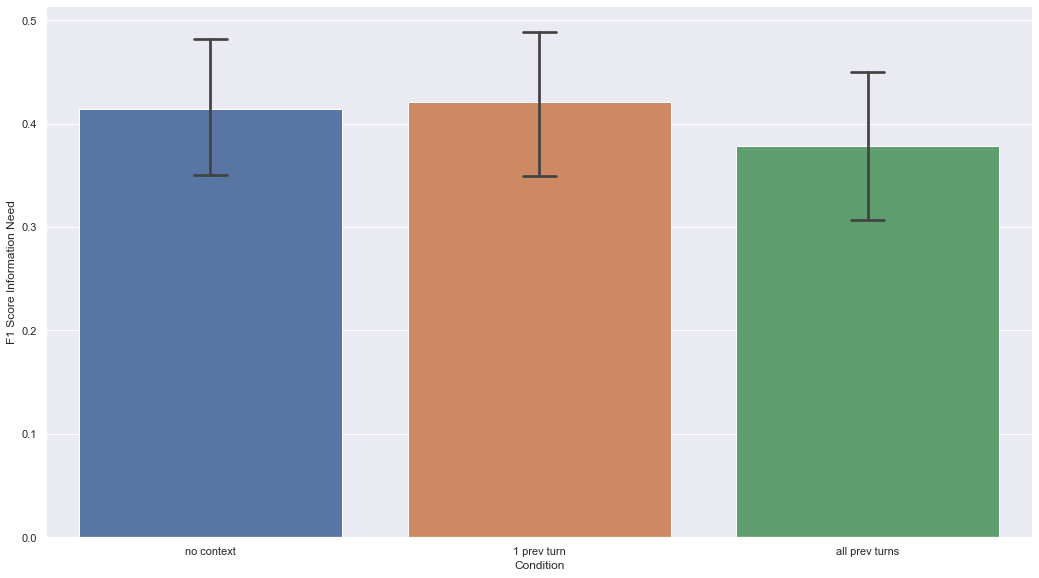

In [33]:
sns.set(style='darkgrid')
gbert_condition_plot = sns.catplot(x="condition", y = "f1_infoneed", 
                                 kind="bar", 
                                 data=gbert_results,
                                 order=["no context", "1 prev turn", "all prev turns"],
                                 height=8,
                                 aspect=1.8,
                                 capsize=.1)
gbert_condition_plot.set_axis_labels("Condition", "F1 Score Information Need")

In [34]:
stats.f_oneway(gbert_results['f1_infoneed'][gbert_results['condition'] == 'no context'],
              gbert_results['f1_infoneed'][gbert_results['condition'] == '1 prev turn'],
              gbert_results['f1_infoneed'][gbert_results['condition'] == 'all prev turns'])

F_onewayResult(statistic=0.418172650772209, pvalue=0.6586000749723144)

In [43]:
sp.posthoc_ttest(gbert_results, val_col='f1_infoneed', group_col='condition',p_adjust='bonferroni')

,all prev turns,no context,1 prev turn
all prev turns,1.0,1.0,1.0
no context,1.0,1.0,1.0
1 prev turn,1.0,1.0,1.0


In [44]:
rp.summary_cont(gbert_results.groupby(['condition'])['f1_infoneed'])

,N,Mean,SD,SE,95% Conf.,Interval
condition,,,,,,
1 prev turn,110,0.4211,0.3660,0.0349,0.3519,0.4903
all prev turns,110,0.3787,0.3788,0.0361,0.3071,0.4503
no context,110,0.4143,0.3628,0.0346,0.3457,0.4828


### GBERT Information Needs Results

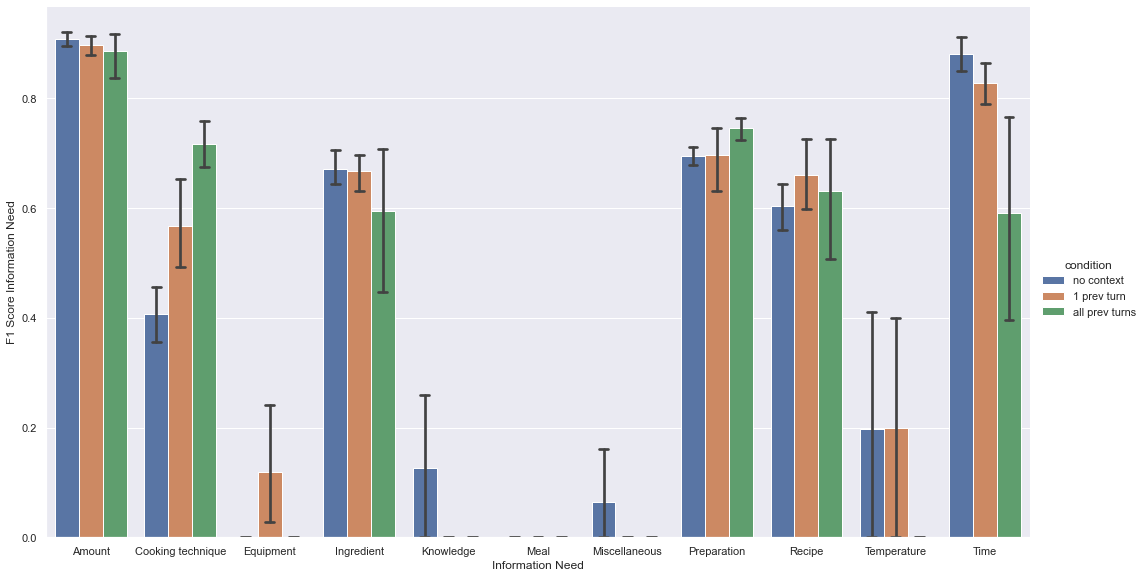

In [52]:
sns.set(style='darkgrid')
gbert_condition_plot = sns.catplot(x="info_need", y = "f1_infoneed", 
                                 hue="condition", 
                                 hue_order = ["no context", "1 prev turn","all prev turns"],
                                 kind="bar", 
                                 data=gbert_results,
                                 height=8,
                                 aspect=1.8,
                                 capsize=.1)
gbert_condition_plot.set_axis_labels("Information Need", "F1 Score Information Need")


### Between-Group Tests

In [35]:
#info = gbert_results[gbert_results['info_need']=="Time"]
"""display(stats.f_oneway(time_results['f1_infoneed'][time_results['info_need'] == 'no_context'],
              time_results['f1_infoneed'][time_results['info_need'] == 'one_prev_utterance'],
             time_results['f1_infoneed'][time_results['info_need'] == 'all_prev_utterance']))"""
display(sp.posthoc_ttest(gbert_results, val_col='f1_infoneed', group_col='info_need',p_adjust='bonferroni'))
gbert_results.groupby(['info_need','condition']).agg({'precision_infoneed':['mean'],
                                                          'recall_infoneed':['mean'],
                                                          'f1_infoneed':['mean'],})

,Amount,Cooking technique,Equipment,Ingredient,Knowledge,Meal,Miscellaneous,Preparation,Recipe,Temperature,Time
Amount,1.000000e+00,1.055984e-13,2.739555e-39,4.885915e-11,1.320479e-33,3.574851e-66,1.979887e-47,1.172373e-16,2.381562e-13,1.156756e-19,1.396940e-01
Cooking technique,1.055984e-13,1.000000e+00,1.744344e-18,1.000000e+00,2.867983e-16,1.091530e-24,2.481081e-21,1.040658e-03,1.000000e+00,4.873868e-08,9.128701e-03
Equipment,2.739555e-39,1.744344e-18,1.000000e+00,6.231514e-23,1.000000e+00,1.000000e+00,1.000000e+00,2.808379e-32,9.262170e-24,1.000000e+00,1.037331e-20
Ingredient,4.885915e-11,1.000000e+00,6.231514e-23,1.000000e+00,3.363196e-20,1.976581e-30,2.499122e-26,1.000000e+00,1.000000e+00,9.275775e-11,8.093402e-01
Knowledge,1.320479e-33,2.867983e-16,1.000000e+00,3.363196e-20,1.000000e+00,1.000000e+00,1.000000e+00,3.010545e-27,1.062531e-20,1.000000e+00,4.000884e-19
Meal,3.574851e-66,1.091530e-24,1.000000e+00,1.976581e-30,1.000000e+00,1.000000e+00,1.000000e+00,2.065253e-52,1.721577e-32,6.492745e-01,1.111069e-24
Miscellaneous,1.979887e-47,2.481081e-21,1.000000e+00,2.499122e-26,1.000000e+00,1.000000e+00,1.000000e+00,2.459080e-39,1.260534e-27,1.000000e+00,1.290816e-22
Preparation,1.172373e-16,1.040658e-03,2.808379e-32,1.000000e+00,3.010545e-27,2.065253e-52,2.459080e-39,1.000000e+00,1.850383e-01,2.859322e-14,1.000000e+00
Recipe,2.381562e-13,1.000000e+00,9.262170e-24,1.000000e+00,1.062531e-20,1.721577e-32,1.260534e-27,1.850383e-01,1.000000e+00,1.049802e-10,3.249314e-01
Temperature,1.156756e-19,4.873868e-08,1.000000e+00,9.275775e-11,1.000000e+00,6.492745e-01,1.000000e+00,2.859322e-14,1.049802e-10,1.000000e+00,4.471549e-12


precision_infoneed recall_infoneed  \
                                               mean            mean   
info_need         condition                                           
Amount            1 prev turn              0.905247        0.891860   
                  all prev turns           0.885121        0.894715   
                  no context               0.904662        0.914799   
Cooking technique 1 prev turn              0.605670        0.554474   
                  all prev turns           0.721192        0.726842   
                  no context               0.366133        0.516579   
Equipment         1 prev turn              0.088333        0.200000   
                  all prev turns           0.000000        0.000000   
                  no context               0.000000        0.000000   
Ingredient        1 prev turn              0.646140        0.699328   
                  all prev turns           0.575303        0.661163   
                  no context               0.643141        0.716511   
Knowledge         1 prev turn              0.000000        0.000000   
                  all prev turns           0.000000        0.000000   
                  no context               0.160000        0.110000   
Meal              1 prev turn              0.000000        0.000000   
                  all prev turns           0.000000        0.000000   
                  no context               0.000000        0.000000   
Miscellaneous     1 prev turn              0.000000        0.000000   
                  all prev turns           0.000000        0.000000   
                  no context               0.125000        0.050000   
Preparation       1 prev turn              0.681468        0.761656   
                  all prev turns           0.758524        0.738571   
                  no context               0.646702        0.758427   
Recipe            1 prev turn              0.662077        0.666959   
                  all prev turns           0.653225        0.709064   
                  no context               0.678705        0.581579   
Temperature       1 prev turn              0.228571        0.200000   
                  all prev turns           0.000000        0.000000   
                  no context               0.200000        0.216667   
Time              1 prev turn              0.833305        0.833824   
                  all prev turns           0.592243        0.766544   
                  no context               0.889891        0.881250   

                                 f1_infoneed  
                                        mean  
info_need         condition                   
Amount            1 prev turn       0.896906  
                  all prev turns    0.886241  
                  no context        0.908741  
Cooking technique 1 prev turn       0.566466  
                  all prev turns    0.716068  
                  no context        0.407180  
Equipment         1 prev turn       0.119170  
                  all prev turns    0.000000  
                  no context        0.000000  
Ingredient        1 prev turn       0.666674  
                  all prev turns    0.594730  
                  no context        0.671831  
Knowledge         1 prev turn       0.000000  
                  all prev turns    0.000000  
                  no context        0.126667  
Meal              1 prev turn       0.000000  
                  all prev turns    0.000000  
                  no context        0.000000  
Miscellaneous     1 prev turn       0.000000  
                  all prev turns    0.000000  
                  no context        0.065000  
Preparation       1 prev turn       0.696317  
                  all prev turns    0.746483  
                  no context        0.695527  
Recipe            1 prev turn       0.659531  
                  all prev turns    0.631484  
                  no context        0.604488  
Temperature       1 prev turn       0.200000  
                  a

### Within-Group Tests

### Time - best condition

In [36]:
time_results = gbert_results[gbert_results['info_need']=="Time"]
display(stats.f_oneway(time_results['f1_infoneed'][time_results['condition'] == 'no_context'],
              time_results['f1_infoneed'][time_results['condition'] == 'one_prev_utterance'],
              time_results['f1_infoneed'][time_results['condition'] == 'all_prev_utterance']))
display(sp.posthoc_ttest(time_results, val_col='f1_infoneed', group_col='condition',p_adjust='bonferroni'))
                 

F_onewayResult(statistic=6.711279338521254, pvalue=0.004305162160055983)

,all_prev_utterance,no_context,one_prev_utterance
all_prev_utterance,1.000000,0.031018,0.097127
no_context,0.031018,1.000000,0.142792
one_prev_utterance,0.097127,0.142792,1.000000


### Recipe - best condition

In [37]:
recipe_results = gbert_results[gbert_results['info_need']=="Recipe"]
display(stats.f_oneway(recipe_results['f1_infoneed'][recipe_results['condition'] == 'no_context'],
              recipe_results['f1_infoneed'][recipe_results['condition'] == 'one_prev_utterance'],
              recipe_results['f1_infoneed'][recipe_results['condition'] == 'all_prev_utterance']))
display(sp.posthoc_ttest(recipe_results, val_col='f1_infoneed', group_col='condition',p_adjust='bonferroni'))
                 

F_onewayResult(statistic=0.43158687281701047, pvalue=0.6538798353993593)

,all_prev_utterance,no_context,one_prev_utterance
all_prev_utterance,1.0,1.000000,1.000000
no_context,1.0,1.000000,0.611811
one_prev_utterance,1.0,0.611811,1.000000


### Ingredient - best condition

In [38]:
ingredient_results = gbert_results[gbert_results['info_need']=="Ingredient"]
display(stats.f_oneway(ingredient_results['f1_infoneed'][ingredient_results['condition'] == 'no_context'],
              ingredient_results['f1_infoneed'][ingredient_results['condition'] == 'one_prev_utterance'],
              ingredient_results['f1_infoneed'][ingredient_results['condition'] == 'all_prev_utterance']))
display(sp.posthoc_ttest(ingredient_results, val_col='f1_infoneed', group_col='condition',p_adjust='bonferroni'))
                 

F_onewayResult(statistic=0.8791038614050193, pvalue=0.42670358896800387)

,all_prev_utterance,no_context,one_prev_utterance
all_prev_utterance,1.0,1.0,1.0
no_context,1.0,1.0,1.0
one_prev_utterance,1.0,1.0,1.0


### Time - best condition

In [36]:
time_results = gbert_results[gbert_results['info_need']=="Time"]
display(stats.f_oneway(time_results['f1_infoneed'][time_results['condition'] == 'no_context'],
              time_results['f1_infoneed'][time_results['condition'] == 'one_prev_utterance'],
              time_results['f1_infoneed'][time_results['condition'] == 'all_prev_utterance']))
display(sp.posthoc_ttest(time_results, val_col='f1_infoneed', group_col='condition',p_adjust='bonferroni'))
                 

F_onewayResult(statistic=6.711279338521254, pvalue=0.004305162160055983)

,all_prev_utterance,no_context,one_prev_utterance
all_prev_utterance,1.000000,0.031018,0.097127
no_context,0.031018,1.000000,0.142792
one_prev_utterance,0.097127,0.142792,1.000000


### Cooking Technique - best condition

In [28]:
cooking_technique_results = gbert_results[gbert_results['info_need']=="Cooking technique"]

In [33]:
stats.f_oneway(cooking_technique_results['f1_infoneed'][cooking_technique_results['condition'] == 'no_context'],
              cooking_technique_results['f1_infoneed'][cooking_technique_results['condition'] == 'one_prev_utterance'],
              cooking_technique_results['f1_infoneed'][cooking_technique_results['condition'] == 'all_prev_utterance'])
                 

F_onewayResult(statistic=21.60815888771832, pvalue=2.4917079050981275e-06)

In [34]:
sp.posthoc_ttest(cooking_technique_results, val_col='f1_infoneed', group_col='condition',p_adjust='bonferroni')


,all_prev_utterance,no_context,one_prev_utterance
all_prev_utterance,1.000000e+00,4.531711e-07,0.024464
no_context,4.531711e-07,1.000000e+00,0.019976
one_prev_utterance,2.446398e-02,1.997591e-02,1.000000


### Preparation - best condition

In [35]:
preparation_results = gbert_results[gbert_results['info_need']=="Preparation"]
stats.f_oneway(preparation_results['f1_infoneed'][preparation_results['condition'] == 'no_context'],
              preparation_results['f1_infoneed'][preparation_results['condition'] == 'one_prev_utterance'],
              preparation_results['f1_infoneed'][preparation_results['condition'] == 'all_prev_utterance'])
                 

F_onewayResult(statistic=2.2285289463499267, pvalue=0.12712074939423965)

In [36]:
sp.posthoc_ttest(preparation_results, val_col='f1_infoneed', group_col='condition',p_adjust='bonferroni')


,all_prev_utterance,no_context,one_prev_utterance
all_prev_utterance,1.000000,0.006486,0.424826
no_context,0.006486,1.000000,1.000000
one_prev_utterance,0.424826,1.000000,1.000000


In [94]:
level0_experiment_results.to_csv("level0_experiment_results.csv",sep=";", quoting=csv.QUOTE_ALL, index=False)

# Model Comparison: Baseline (no stopwords) - BERT 

In [21]:
all_experiment_results = pd.concat([level0_experiment_results,baseline_data_no_stopwords_no_resampling], ignore_index=True)

In [22]:
all_experiment_results.groupby(['model','condition']).agg({'precision_infoneed':['mean'],
                                                          'recall_infoneed':['mean'],
                                                          'f1_infoneed':['mean'],})

precision_infoneed  \
                                                          mean   
model                        condition                           
NB                           1 prev turn              0.191394   
                             all prev turns           0.140946   
                             no context               0.191986   
RF                           1 prev turn              0.275148   
                             all prev turns           0.027883   
                             no context               0.349654   
SVM                          1 prev turn              0.254977   
                             all prev turns           0.011364   
                             no context               0.324147   
bert-base-multilingual-cased 1 prev turn              0.337644   
                             all prev turns           0.212572   
                             no context               0.344174   
deepset/gbert-base           1 prev turn              0.422801   
                             all prev turns           0.380510   
                             no context               0.419476   
xlm-roberta-base             1 prev turn              0.193248   
                             all prev turns           0.153745   
                             no context               0.265798   

                                            recall_infoneed f1_infoneed  
                                                       mean        mean  
model                        condition                                   
NB                           1 prev turn           0.606744    0.252121  
                             all prev turns        0.459931    0.195092  
                             no context            0.607208    0.236774  
RF                           1 prev turn           0.043546    0.072103  
                             all prev turns        0.038554    0.026910  
                             no context            0.130197    0.183037  
SVM                          1 prev turn           0.071075    0.104862  
                             all prev turns        0.000887    0.001593  
                             no context            0.145081    0.191322  
bert-base-multilingual-cased 1 prev turn           0.385596    0.344552  
                             all prev turns        0.320879    0.228195  
                             no context            0.368438    0.341752  
deepset/gbert-base           1 prev turn           0.437100    0.421099  
                             all prev turns        0.408809    0.378704  
                             no context            0.431437    0.414292  
xlm-roberta-base             1 prev turn           0.299366    0.203558  
                             all prev turns        0.335879    0.186377  
                             no context            0.349175    0.276096

In [23]:
rp.summary_cont(all_experiment_results.groupby(['model','condition'])['f1_infoneed'])

N    Mean      SD      SE  \
model                        condition                                     
NB                           1 prev turn     110  0.2521  0.1722  0.0164   
                             all prev turns  110  0.1951  0.2064  0.0197   
                             no context      110  0.2368  0.1712  0.0163   
RF                           1 prev turn     110  0.0721  0.1107  0.0106   
                             all prev turns  110  0.0269  0.0625  0.0060   
                             no context      110  0.1830  0.2044  0.0195   
SVM                          1 prev turn     110  0.1049  0.1664  0.0159   
                             all prev turns  110  0.0016  0.0118  0.0011   
                             no context      110  0.1913  0.2758  0.0263   
bert-base-multilingual-cased 1 prev turn     110  0.3446  0.3494  0.0333   
                             all prev turns  110  0.2282  0.2768  0.0264   
                             no context      110  0.3418  0.3529  0.0336   
deepset/gbert-base           1 prev turn     110  0.4211  0.3660  0.0349   
                             all prev turns  110  0.3787  0.3788  0.0361   
                             no context      110  0.4143  0.3628  0.0346   
xlm-roberta-base             1 prev turn     110  0.2036  0.2991  0.0285   
                             all prev turns  110  0.1864  0.2359  0.0225   
                             no context      110  0.2761  0.3490  0.0333   

                                             95% Conf.  Interval  
model                        condition                            
NB                           1 prev turn        0.2196    0.2847  
                             all prev turns     0.1561    0.2341  
                             no context         0.2044    0.2691  
RF                           1 prev turn        0.0512    0.0930  
                             all prev turns     0.0151    0.0387  
                             no context         0.1444    0.2217  
SVM                          1 prev turn        0.0734    0.1363  
                             all prev turns    -0.0006    0.0038  
                             no context         0.1392    0.2434  
bert-base-multilingual-cased 1 prev turn        0.2785    0.4106  
                             all prev turns     0.1759    0.2805  
                             no context         0.2751    0.4084  
deepset/gbert-base           1 prev turn        0.3519    0.4903  
                             all prev turns     0.3071    0.4503  
                             no context         0.3457    0.4828  
xlm-roberta-base             1 prev turn        0.1470    0.2601  
                             all prev turns     0.1418    0.2309  
                             no context         0.2101    0.3420

In [42]:
nb_bert_no_stop_no_res = all_experiment_results[all_experiment_results['model'].isin(['NB',
                                                                                      'deepset/gbert-base',
                                                                                     'xlm-roberta-base',
                                                                                     'bert-base-multilingual-cased'])]

In [43]:
display(Markdown("**OVERALL MODEL PERFORMANCE BASELINE - BERT**"))
overall_model_comparison = stats.f_oneway(nb_bert_no_stop_no_res['f1_infoneed'][nb_bert_no_stop_no_res['model'] == 'deepset/gbert-base'],
                                    nb_bert_no_stop_no_res['f1_infoneed'][nb_bert_no_stop_no_res['model'] == 'xlm-roberta-base'],
                                    nb_bert_no_stop_no_res['f1_infoneed'][nb_bert_no_stop_no_res['model'] == 'bert-base-multilingual-cased'],
                                         nb_bert_no_stop_no_res['f1_infoneed'][nb_bert_no_stop_no_res['model'] == 'NB'])
print(overall_model_comparison)
overall_model_posthoc = sp.posthoc_ttest(nb_bert_no_stop_no_res, val_col='f1_infoneed', group_col='model',p_adjust='bonferroni')
display(overall_model_posthoc)
display(rp.summary_cont(nb_bert_no_stop_no_res['f1_infoneed'].groupby(nb_bert_no_stop_no_res['model'])))


**OVERALL MODEL PERFORMANCE BASELINE - BERT**

F_onewayResult(statistic=25.97197285616649, pvalue=2.533258191222304e-16)


,bert-base-multilingual-cased,deepset/gbert-base,xlm-roberta-base,NB
bert-base-multilingual-cased,1.000000,1.643900e-03,4.863385e-03,1.542537e-03
deepset/gbert-base,0.001644,1.000000e+00,4.219362e-11,1.653129e-13
xlm-roberta-base,0.004863,4.219362e-11,1.000000e+00,1.000000e+00
NB,0.001543,1.653129e-13,1.000000e+00,1.000000e+00


,N,Mean,SD,SE,95% Conf.,Interval
model,,,,,,
NB,330,0.2280,0.1850,0.0102,0.2080,0.2480
bert-base-multilingual-cased,330,0.3048,0.3317,0.0183,0.2689,0.3408
deepset/gbert-base,330,0.4047,0.3686,0.0203,0.3648,0.4446
xlm-roberta-base,330,0.2220,0.2999,0.0165,0.1895,0.2545


# Need Type Analysis on Level 0

In [36]:
need_type_experiment_results = pd.DataFrame(columns=['loss', 'task_name', 'info_need','model', 'num_epochs', 'condition',
                            'acc','f1_other','f1_infoneed','precision_infoneed','recall_infoneed',
                            'recall_other','precision_other','recall_macro','precision_macro',
                            'recall_micro','precision_micro','recall_weighted','precision_weighted',
                            'f1_weighted','f1_macro','f1_micro','mcc','report','preds','labels'])
all_files = glob.glob('classification_results/level_0/*.json')
all_rows = []
for file in all_files:
    with open(file) as data_file:    
        data = json.load(data_file)  
    for fold in data:
        temp_df = pd.json_normalize(fold)
        need_type_experiment_results = need_type_experiment_results.append(temp_df, ignore_index = True)
display(need_type_experiment_results)

,loss,task_name,info_need,model,num_epochs,condition,acc,f1_other,f1_infoneed,precision_infoneed,...,precision_micro,recall_weighted,precision_weighted,f1_weighted,f1_macro,f1_micro,mcc,report,preds,labels
0,0.692503,text_classification,competence,bert-base-multilingual-cased,4,all_prev_utterance,0.466942,0.364532,0.540925,0.395833,...,0.466942,0.466942,0.613426,0.429404,0.452729,0.466942,0.114052,precision recall f1-score ...,"[competence, competence, Other, competence, co...","[competence, Other, Other, competence, compete..."
1,0.687022,text_classification,competence,bert-base-multilingual-cased,4,all_prev_utterance,0.570248,0.653333,0.434783,0.421053,...,0.570248,0.570248,0.576338,0.572957,0.544058,0.570248,0.088833,precision recall f1-score ...,"[Other, Other, competence, competence, Other, ...","[Other, Other, Other, Other, Other, competence..."
2,0.692587,text_classification,competence,bert-base-multilingual-cased,4,all_prev_utterance,0.388430,0.139535,0.525641,0.367713,...,0.388430,0.388430,0.534537,0.281533,0.332588,0.388430,-0.000395,precision recall f1-score ...,"[competence, competence, competence, competenc...","[Other, Other, Other, Other, Other, competence..."
3,0.690274,text_classification,competence,bert-base-multilingual-cased,4,all_prev_utterance,0.429752,0.188235,0.560510,0.391111,...,0.429752,0.429752,0.738880,0.325146,0.374372,0.429752,0.176112,precision recall f1-score ...,"[Other, competence, competence, competence, co...","[Other, competence, Other, competence, Other, ..."
4,0.688819,text_classification,competence,bert-base-multilingual-cased,4,all_prev_utterance,0.545455,0.566929,0.521739,0.425532,...,0.545455,0.545455,0.607197,0.550310,0.544334,0.545455,0.141539,precision recall f1-score ...,"[competence, Other, Other, Other, competence, ...","[Other, competence, Other, Other, competence, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.640925,text_classification,fact,xlm-roberta-base,4,one_prev_utterance,0.818182,0.738095,0.860759,0.834356,...,0.818182,0.818182,0.816134,0.815647,0.799427,0.818182,0.602107,precision recall f1-score ...,"[fact, Other, fact, fact, fact, fact, fact, fa...","[fact, Other, fact, fact, fact, fact, fact, fa..."
176,0.500087,text_classification,fact,xlm-roberta-base,4,one_prev_utterance,0.731405,0.697674,0.758364,0.879310,...,0.731405,0.731405,0.774837,0.736044,0.728019,0.731405,0.491648,precision recall f1-score ...,"[Other, Other, Other, fact, Other, fact, Other...","[Other, Other, fact, fact, fact, fact, Other, ..."
177,0.487622,text_classification,fact,xlm-roberta-base,4,one_prev_utterance,0.818182,0.770833,0.849315,0.885714,...,0.818182,0.818182,0.826127,0.820128,0.810074,0.818182,0.624464,precision recall f1-score ...,"[Other, fact, Other, Other, Other, fact, fact,...","[Other, Other, Other, Other, fact, fact, fact,..."
178,0.513895,text_classification,fact,xlm-roberta-base,4,one_prev_utterance,0.809129,0.744444,0.847682,0.853333,...,0.809129,0.809129,0.810100,0.809557,0.796063,0.809129,0.592250,precision recall f1-score ...,"[fact, fact, fact, Other, Other, Other, fact, ...","[fact, fact, fact, Other, Other, Other, Other,..."


In [37]:
gbert_need_type_experiment_results = need_type_experiment_results[~need_type_experiment_results.model.isin(['xlm-roberta-base','bert-base-multilingual-cased'])]
gbert_need_type_experiment_results['condition'] = gbert_need_type_experiment_results['condition'].replace({'no_context':'no context', 
                                                    'one_prev_utterance': '1 prev turn',
                                                    'all_prev_utterance': 'all prev turns'
                                                   })

In [38]:
gbert_need_type_experiment_results.groupby(['info_need','condition']).agg({'precision_infoneed':['mean'],
                                                          'recall_infoneed':['mean'],
                                                          'f1_infoneed':['mean'],})

precision_infoneed recall_infoneed f1_infoneed
                                        mean            mean        mean
info_need  condition                                                    
competence 1 prev turn              0.774632        0.792360    0.781745
           all prev turns           0.671120        0.744007    0.691582
           no context               0.745414        0.799039    0.770077
fact       1 prev turn              0.833126        0.897093    0.856218
           all prev turns           0.885482        0.884069    0.884129
           no context               0.881978        0.839564    0.859910

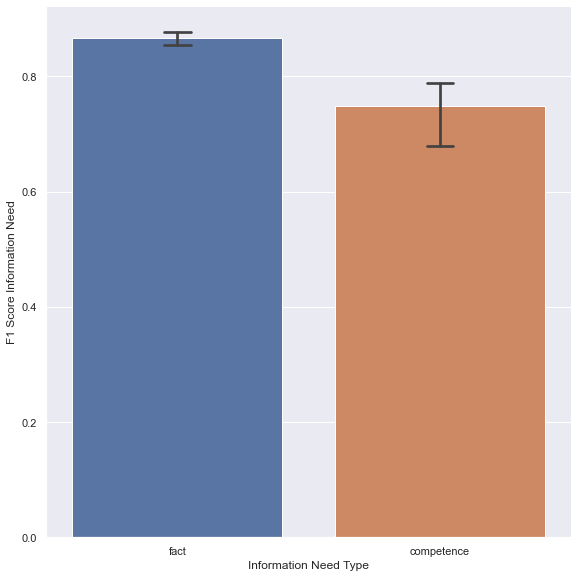

In [39]:
gbert_condition_plot = sns.catplot(x="info_need", y = "f1_infoneed", 
                                 kind="bar", 
                                 data=gbert_need_type_experiment_results,
                                 height=8,
                                 capsize=.1,
                                 order=["fact","competence"])
gbert_condition_plot.set_axis_labels("Information Need Type", "F1 Score Information Need")
# ci intervalls are bootstrapeed automatically
# https://seaborn.pydata.org/generated/seaborn.barplot.html#seaborn.barplot

### Test Fact vs. Competence

In [41]:
display(rp.summary_cont(gbert_need_type_experiment_results['f1_infoneed'].groupby(gbert_need_type_experiment_results['info_need'])))
display(stats.ttest_ind(gbert_need_type_experiment_results['f1_infoneed'][gbert_need_type_experiment_results['info_need']=='fact'],
                       gbert_need_type_experiment_results['f1_infoneed'][gbert_need_type_experiment_results['info_need']=='competence']))


,N,Mean,SD,SE,95% Conf.,Interval
info_need,,,,,,
competence,30,0.7478,0.1516,0.0277,0.6912,0.8044
fact,30,0.8668,0.0326,0.0060,0.8546,0.8789


Ttest_indResult(statistic=4.201276031188881, pvalue=9.267592611053376e-05)

In [42]:
display(Markdown("**LEVEL 0 NEED TYPE PERFORMANCE**"))
need_type_comparison = stats.f_oneway(need_type_experiment_results['f1_infoneed'][need_type_experiment_results['model'] == 'deepset/gbert-base'],
                                    need_type_experiment_results['f1_infoneed'][need_type_experiment_results['model'] == 'xlm-roberta-base'],
                                    need_type_experiment_results['f1_infoneed'][need_type_experiment_results['model'] == 'bert-base-multilingual-cased'])
print(overall_model_comparison)
overall_model_posthoc = sp.posthoc_ttest(need_type_experiment_results, val_col='f1_infoneed', group_col='model',p_adjust='bonferroni')
display(overall_model_posthoc)


**LEVEL 0 NEED TYPE PERFORMANCE**

F_onewayResult(statistic=24.669353046255857, pvalue=3.510884801144857e-11)


,bert-base-multilingual-cased,deepset/gbert-base,xlm-roberta-base
bert-base-multilingual-cased,1.000000,0.002609,0.382777
deepset/gbert-base,0.002609,1.000000,0.000161
xlm-roberta-base,0.382777,0.000161,1.000000
